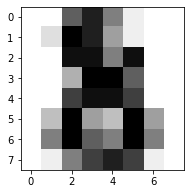

In [50]:
from sklearn import datasets 

import matplotlib.pyplot as plt

#Load the digits dataset -  1797 8x8 images
digits = datasets.load_digits()

#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[-1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
# filter warnings
warnings.filterwarnings('ignore')

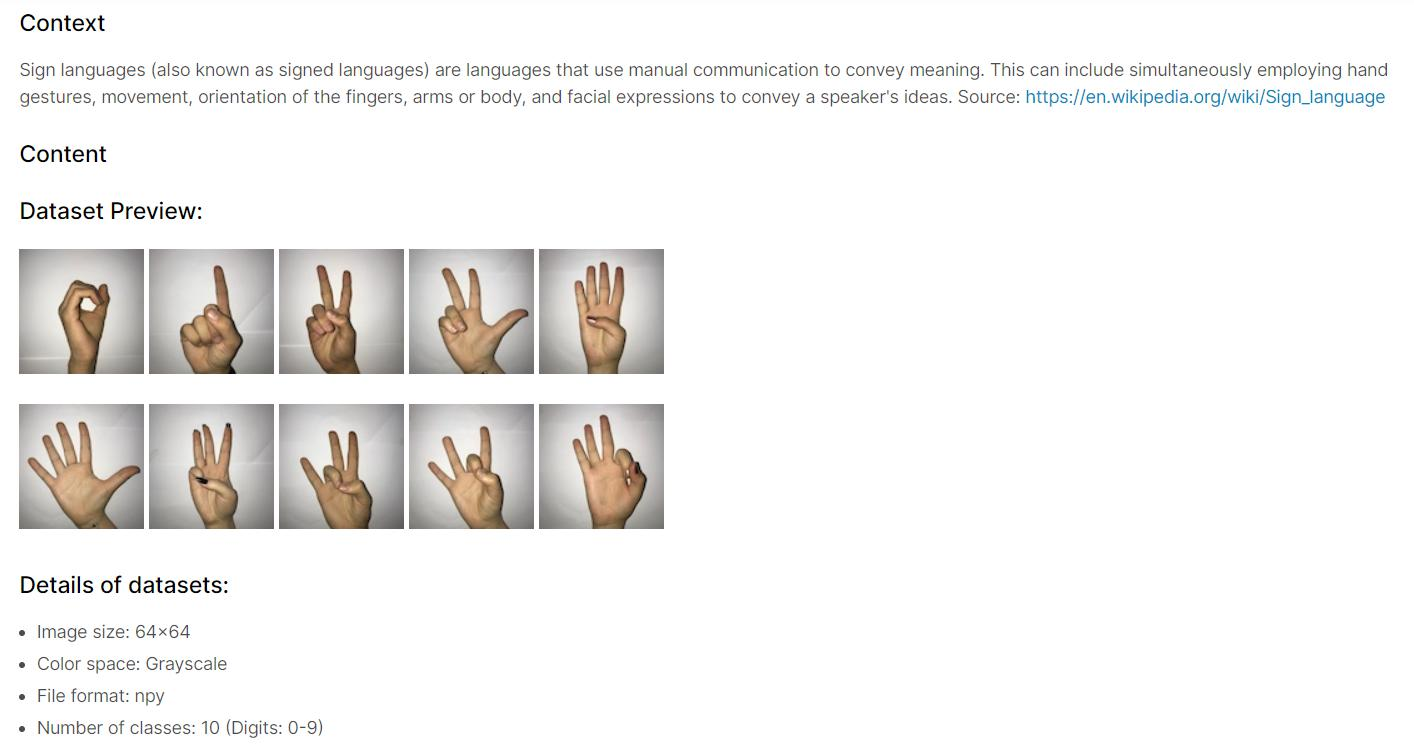

Citations: Mavi, A., (2020), “A New Dataset and Proposed Convolutional Neural Network Architecture for Classification of American Sign Language Digits”, 
    arXiv:2011.08927 [cs.CV]

In [3]:
# load data set
X = np.load('X.npy')
Y = np.load('Y.npy')
X.shape, Y.shape
# Note the coolor space is Grayscale, Shape is layers, rows and columns for 3d arrays

((2062, 64, 64), (2062, 10))

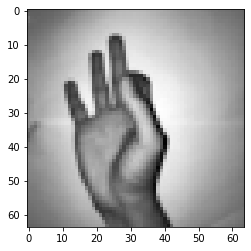

In [4]:
plt.imshow(X[0,:,:], cmap='gray')

In [11]:
#dictionary that handles the column index - digit relatinship
colidx_digit = {0: 9,
                1: 0,
                2: 7,
                3: 6,
                4: 1,
                5: 8,
                6: 4,
                7: 3,
                8: 2,
                9: 5}

#digit - column index relationship dictionary
digit_colidx = {v: k for k, v in colidx_digit.items()}

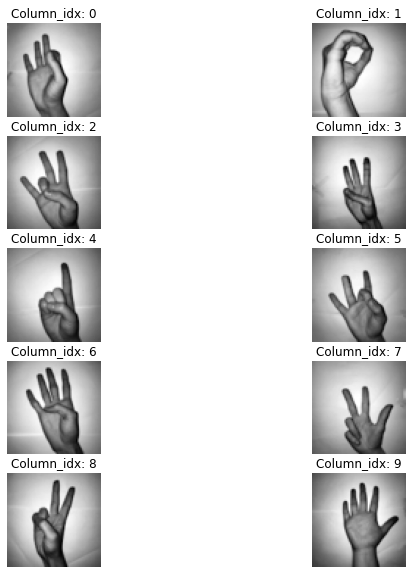

In [13]:
N_classes = Y.shape[1]
col_idx = [i for i in range(N_classes)]
plot_digits_colidx(X, Y)

In [14]:
#Let't capture this in a dictionary, and let's transform the Y matrix so that its column indeces 
# correspond to the digit they represent
#create empty matrix
Y_ordered = np.zeros(Y.shape)
#fill the matrix so that the columns index also corresponds to the digit
for i in range(N_classes):
    Y_ordered[:, i] = Y[:, digit_colidx[i]]

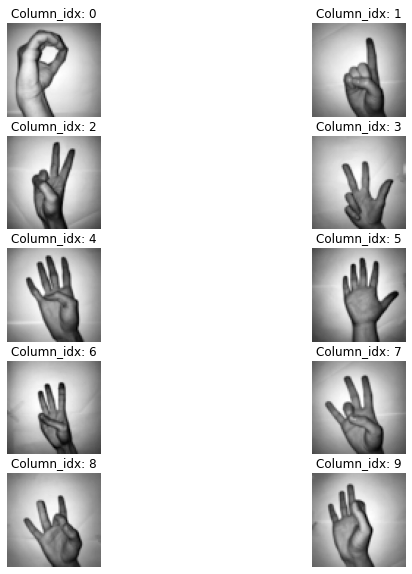

In [15]:
plot_digits_colidx(X, Y_ordered)

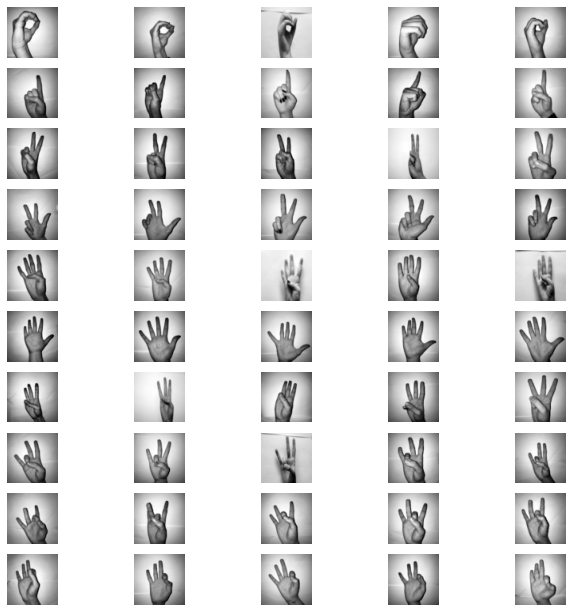

In [17]:
#N images per row
N_im_lab = 5
plt.figure(figsize=(11,11))
plt.plot([N_classes, N_im_lab, (N_im_lab * N_classes) + 1])

#for every label
for lab in range(N_classes):
    #show N_im_lab first samples
    for i in range(N_im_lab):
        ax = plt.subplot(N_classes, N_im_lab, 1 + (i + (lab*N_im_lab)))
        plt.axis('off')
        plt.imshow(X[np.argwhere(Y_ordered[:,lab]==1)[i][0],:], cmap='gray')

## KERAS Model

In [18]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Activation, Flatten

In [19]:
def keras_lr(input_shape):
    #input layer
    X_input = Input(input_shape)
    #flatten
    X = Flatten()(X_input)
    #dense layer
    X = Dense(N_classes, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='keras_lr')
    return model

In [20]:
lr_model = keras_lr((64, 64, 1))

In [21]:
lr_model.summary()

Model: "keras_lr"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [38]:
#set the optimization
lr_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["acc"])

In [39]:
#reshape the data, to adapt the shape to the keras expectation
X = X.reshape(X.shape[0], 64, 64, 1)

#train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y_ordered, random_state=4)

In [40]:
#fit the model
lr_fit_hist = lr_model.fit(x = X_train , y = y_train, validation_data = (X_test, y_test), epochs = 500, batch_size = 128, verbose=0)

In [41]:
#show the train-test accuracy depending on the epoch
def plot_acc_vs_epoch(fit_history):
    plt.plot(fit_history.history['acc'])
    plt.plot(fit_history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

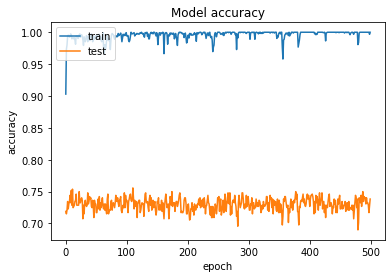

In [42]:
plot_acc_vs_epoch(lr_fit_hist)

In [43]:
#evaluate the model performance in the validation set
evs = lr_model.evaluate(x = X_test, y = y_test)
#show the accuracy metric
print(evs[1])

17/17 [==============================] - 0s 997us/step - loss: 1.1817 - acc: 0.7384
0.7383720874786377


In [44]:
#fit the baseline model
base_model = keras_lr((64, 64, 1))
base_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])
basline_fit_hist = base_model.fit(x = X_train , y = y_train, validation_data = (X_test, y_test), epochs = 200, batch_size = 128, verbose=0)
#baseline model accuracy
base_model.evaluate(x = X_test, y = y_test)[1]

17/17 [==============================] - 0s 1ms/step - loss: 0.8454 - accuracy: 0.7384


0.7383720874786377

In [45]:
#compute confusion matrix
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

def plot_conf_matrix(y_true, y_pred, set_str):
    """
    This function plots a basic confusion matrix
    """
    conf_mat = confusion_matrix(y_true, y_pred)
    df_conf = pd.DataFrame(conf_mat, index = ['Digit - ' + str(i) for i in range(N_classes)],
                           columns = ['Digit - ' + str(i) for i in range(N_classes)])

    plt.figure(figsize = (12, 12))
    sn.heatmap(df_conf, annot=True, cmap="YlGnBu")

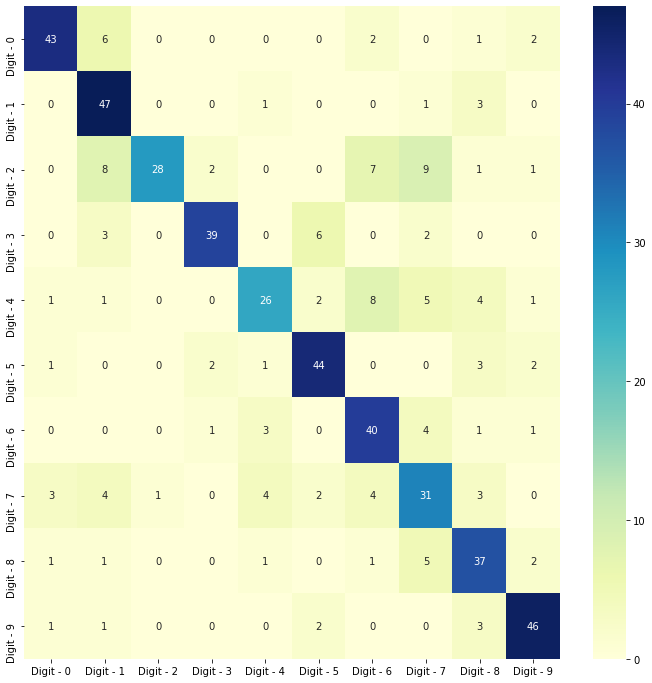

In [46]:
#class estimation
base_y_test_pred = base_model.predict(X_test)
plot_conf_matrix(y_test.argmax(axis=1), base_y_test_pred.argmax(axis=1), '')

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), base_y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        54
           1       0.66      0.90      0.76        52
           2       0.97      0.50      0.66        56
           3       0.89      0.78      0.83        50
           4       0.72      0.54      0.62        48
           5       0.79      0.83      0.81        53
           6       0.65      0.80      0.71        50
           7       0.54      0.60      0.57        52
           8       0.66      0.77      0.71        48
           9       0.84      0.87      0.85        53

    accuracy                           0.74       516
   macro avg       0.76      0.74      0.74       516
weighted avg       0.76      0.74      0.74       516

